In [1]:
import numpy as np


np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)



岭回归(也称为Tikhonov正则化)是线性回归的L2正则化版本:

$$
J(\theta) = MSE(\theta) = \alpha \frac{1}{2}\sum_{i=1}^n \theta_i ^2
$$


In [2]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [3]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

线性回归的另一种正则化叫作最小绝对收缩和选择算子回归 (Least Absolute Shrinkage and Selection Operator Regression， 简称Lasso回归)也就是L1正则
$$
J(\theta) = MSE(\theta) = \alpha \sum_{i=1}^n| \theta_i |
$$

In [4]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

弹性网络是介于岭回归和Lasso回归之间的中间地带。正则项是岭 和Lasso正则项的简单混合，你可以控制混合比r。当r=0时，弹性网络 等效于岭回归，而当r=1时，弹性网络等效于Lasso回归
$$
J(\theta) = MSE(\theta) = \alpha \frac{1-r}{2}\sum_{i=1}^n \theta_i ^2 + \alpha r\sum_{i=1}^n |\theta_i|
$$






In [5]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

那么什么时候应该使用普通的线性回归(即不进行任何正则化)、 岭回归、Lasso或弹性网络呢?通常来说，有正则化——哪怕很小，总比没 有更可取一些。所以大多数情况下，你应该避免使用纯线性回归。岭回 归是个不错的默认选择，但是如果你觉得实际用到的特征只有少数几 个，那就应该更倾向于Lasso回归或是弹性网络，因为它们会将无用特 征的权重降为零。一般而言，弹性网络优于Lasso回归，因为当特征数 量超过训练实例数量，又或者是几个特征强相关时，Lasso回归的表现 可能非常不稳定。


## 提前停止
使用随机和小批量梯度下降时，曲线不是那么平滑，可能很难
知道你是否达到了最小值。一种解决方案是仅在验证错误超过最小值一
段时间后停止(当你确信模型不会做得更好时)，然后回滚模型参数到
验证误差最小的位置。


In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [7]:
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor


poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# 请注意，在使用warm_start=True的情况下，当调用fit()方法 时，它将在停止的地方继续训练，而不是从头开始。
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

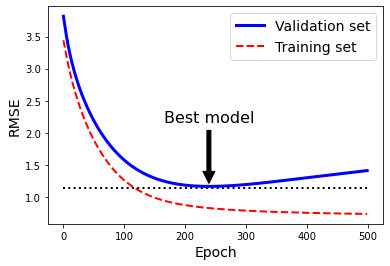

In [8]:
import matplotlib.pyplot as plt
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

逻辑回归 sigmoid 二分类问题

In [9]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

/var/folders/70/f68hms5512gffmdv178wlrvc0000gn/T/ipykernel_3552/3966719491.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0


In [10]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

In [11]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])